In [10]:
import pandas as pd
import pandas_ta as ta

In [11]:
def read_csv(ticker):
    df = pd.read_csv(f"../data/1d/{ticker}.csv")
    df.set_index("Date", inplace=True)
    return df

df = read_csv("PLTR")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-09-30 00:00:00-04:00,10.00,11.410,9.11,9.500,338584400,0.0,0.0
2020-10-01 00:00:00-04:00,9.69,10.100,9.23,9.460,124297600,0.0,0.0
2020-10-02 00:00:00-04:00,9.06,9.280,8.94,9.200,55018300,0.0,0.0
2020-10-05 00:00:00-04:00,9.43,9.490,8.92,9.030,36316900,0.0,0.0
2020-10-06 00:00:00-04:00,9.04,10.180,8.90,9.900,90864000,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-17 00:00:00-04:00,9.54,10.285,9.46,10.250,63834500,0.0,0.0
2023-05-18 00:00:00-04:00,10.46,11.810,10.39,11.740,171402300,0.0,0.0
2023-05-19 00:00:00-04:00,11.97,12.410,11.52,11.710,148321300,0.0,0.0


In [12]:
import numpy as np

# Squeeze Momentum Indicator

LENGTH_BB = 20 # BB Length
MULT_BB = 2 # BB Multiplier
LENGTH_KC = 20 # KC Length
MULT_KC = 1.5 # KC Multiplier

USE_TRUE_RANGE = True # Use True Range for KC

# Calculate BB
source = df["Close"]
basis = ta.sma(source, length=LENGTH_BB)
dev = MULT_KC * ta.stdev(source, length=LENGTH_BB)

upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.sma(source, length=LENGTH_KC)
range_val = ta.true_range(df["High"], df["Low"], df["Close"]) if USE_TRUE_RANGE else df["High"] - df["Low"]
rangema = ta.sma(range_val, length=LENGTH_KC)
upperKC = ma + rangema * MULT_KC
lowerKC = ma - rangema * MULT_KC

# Calculate Squeeze
sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = ~sqzOn & ~sqzOff

# Calculate Momentum
avg_high_low = (df["High"].rolling(LENGTH_KC).max() + df["Low"].rolling(LENGTH_KC).min())/2
sma_close = ta.sma(df["Close"], LENGTH_KC)
val = ta.linreg(source - (avg_high_low + sma_close)/2, LENGTH_KC, 0)

# replace all NaN values with 0
val = val.replace(np.nan, 0)

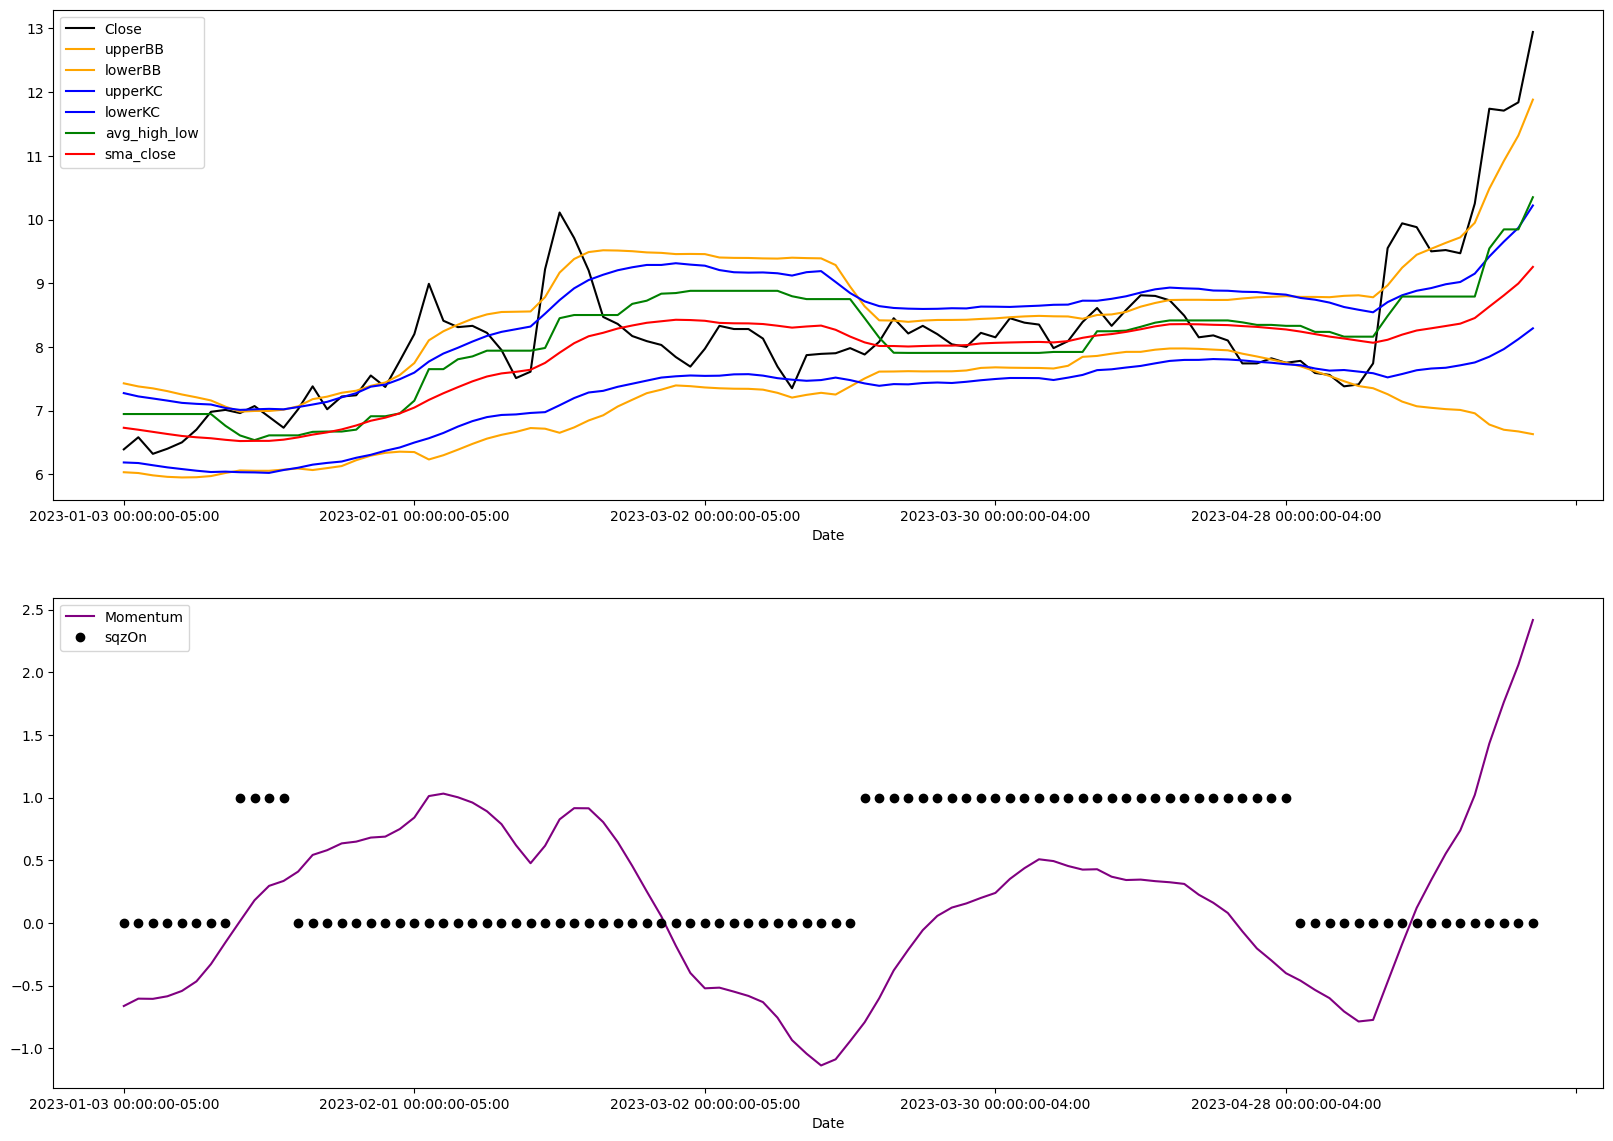

In [13]:
cutoff = "2023-01-01"
df = df[df.index > cutoff]
upperBB = upperBB[upperBB.index > cutoff]
lowerBB = lowerBB[lowerBB.index > cutoff]
upperKC = upperKC[upperKC.index > cutoff]
lowerKC = lowerKC[lowerKC.index > cutoff]
avg_high_low = avg_high_low[avg_high_low.index > cutoff]
sma_close = sma_close[sma_close.index > cutoff]
sqzOn = sqzOn[sqzOn.index > cutoff]
sqzOff = sqzOff[sqzOff.index > cutoff]
val = val[val.index > cutoff]

import matplotlib.pyplot as plt
# set figsize big height
plt.subplot(2, 1, 1)

# plot the data
df["Close"].plot(figsize=(20,80), color="black")
upperBB.plot(figsize=(20,8), color="orange")
lowerBB.plot(figsize=(20,8), color="orange")
upperKC.plot(figsize=(20,8), color="blue")
lowerKC.plot(figsize=(20,8), color="blue")

avg_high_low.plot(figsize=(20,8), color="green")
sma_close.plot(figsize=(20,8), color="red")

plt.legend(["Close", "upperBB", "lowerBB", "upperKC", "lowerKC", "avg_high_low", "sma_close"])

plt.subplot(2, 1, 2)
val.plot(figsize=(20,80), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
sqzOn.astype(int).plot(figsize=(20,14), color="black", marker="o", linestyle="None")

plt.legend(["Momentum", "sqzOn"])

In [14]:
lefbars = 5
rightbars = 5
volume_threshold = 10


In [15]:
from collections import deque
import numpy as np


def clean_deque(i, k, deq, df, key, isHigh):
    if deq and deq[0] == i - k:
        deq.popleft()
    if isHigh:
        while deq and df.iloc[i][key] > df.iloc[deq[-1]][key]:
            deq.pop()
    else:
        while deq and df.iloc[i][key] < df.iloc[deq[-1]][key]:
            deq.pop()

def pivotPoints(pivot=None,data=None):
    """
    This function calculates the pivot points based on the pivot lenght.
    These can be HH, LH , HL, LL values based on the adjacent pivots 
    which occur based on the length of the pivot.
    """

    data['PH'] = False
    data['PHV'] = np.NaN
    data['PL'] = False
    data['PLV'] = np.NaN
    keyHigh = 'High'
    keyLow = 'Low'
    win_size = pivot * 2 + 1
    deqHigh = deque()
    deqLow = deque()
    max_idx = 0
    min_idx = 0
    i = 0
    j = pivot
    pivot_low = None
    pivot_high = None
    for index, row in data.iterrows():
        if i < win_size:
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            if data.iloc[i][keyHigh] > data.iloc[max_idx][keyHigh]:
                max_idx = i
            if data.iloc[i][keyLow] < data.iloc[min_idx][keyLow]:
                min_idx = i
            if i == win_size-1:
                if data.iloc[max_idx][keyHigh] == data.iloc[j][keyHigh]:
                    data.at[data.index[j], 'PH'] = True
                    pivot_high = data.iloc[j][keyHigh]
                if data.iloc[min_idx][keyLow] == data.iloc[j][keyLow]:
                    data.at[data.index[j], 'PL'] = True
                    pivot_low = data.iloc[j][keyLow]
        if i >= win_size:
            j += 1
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            pivot_val = data.iloc[deqHigh[0]][keyHigh]
            if pivot_val == data.iloc[j][keyHigh]:
                data.at[data.index[j], 'PH'] = True
                pivot_high = data.iloc[j][keyHigh]
            if data.iloc[deqLow[0]][keyLow] == data.iloc[j][keyLow]:
                data.at[data.index[j], 'PL'] = True
                pivot_low = data.iloc[j][keyLow]

        data.at[data.index[j], 'PHV'] = pivot_high
        data.at[data.index[j], 'PLV'] = pivot_low
        i = i + 1

    return data

In [16]:
pivots = pivotPoints(pivot=1,data=df)
pivots

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_43163/2714517808.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PH'] = False
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_43163/2714517808.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PHV'] = np.NaN
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_43163/2714517808.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PH,PHV,PL,PLV
Date,,,,,,,,,,,
2023-01-03 00:00:00-05:00,6.58,6.640,6.275,6.390,29969900,0.0,0.0,False,NaN,False,NaN
2023-01-04 00:00:00-05:00,6.48,6.675,6.370,6.580,31660500,0.0,0.0,True,6.675,False,NaN
2023-01-05 00:00:00-05:00,6.45,6.490,6.250,6.320,34186000,0.0,0.0,False,6.675,False,NaN
2023-01-06 00:00:00-05:00,6.40,6.450,6.090,6.400,30596400,0.0,0.0,False,6.675,True,6.09
2023-01-09 00:00:00-05:00,6.49,6.670,6.400,6.500,31028900,0.0,0.0,False,6.675,False,6.09
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17 00:00:00-04:00,9.54,10.285,9.460,10.250,63834500,0.0,0.0,False,10.300,False,9.02
2023-05-18 00:00:00-04:00,10.46,11.810,10.390,11.740,171402300,0.0,0.0,False,10.300,False,9.02
2023-05-19 00:00:00-04:00,11.97,12.410,11.520,11.710,148321300,0.0,0.0,True,12.410,False,9.02


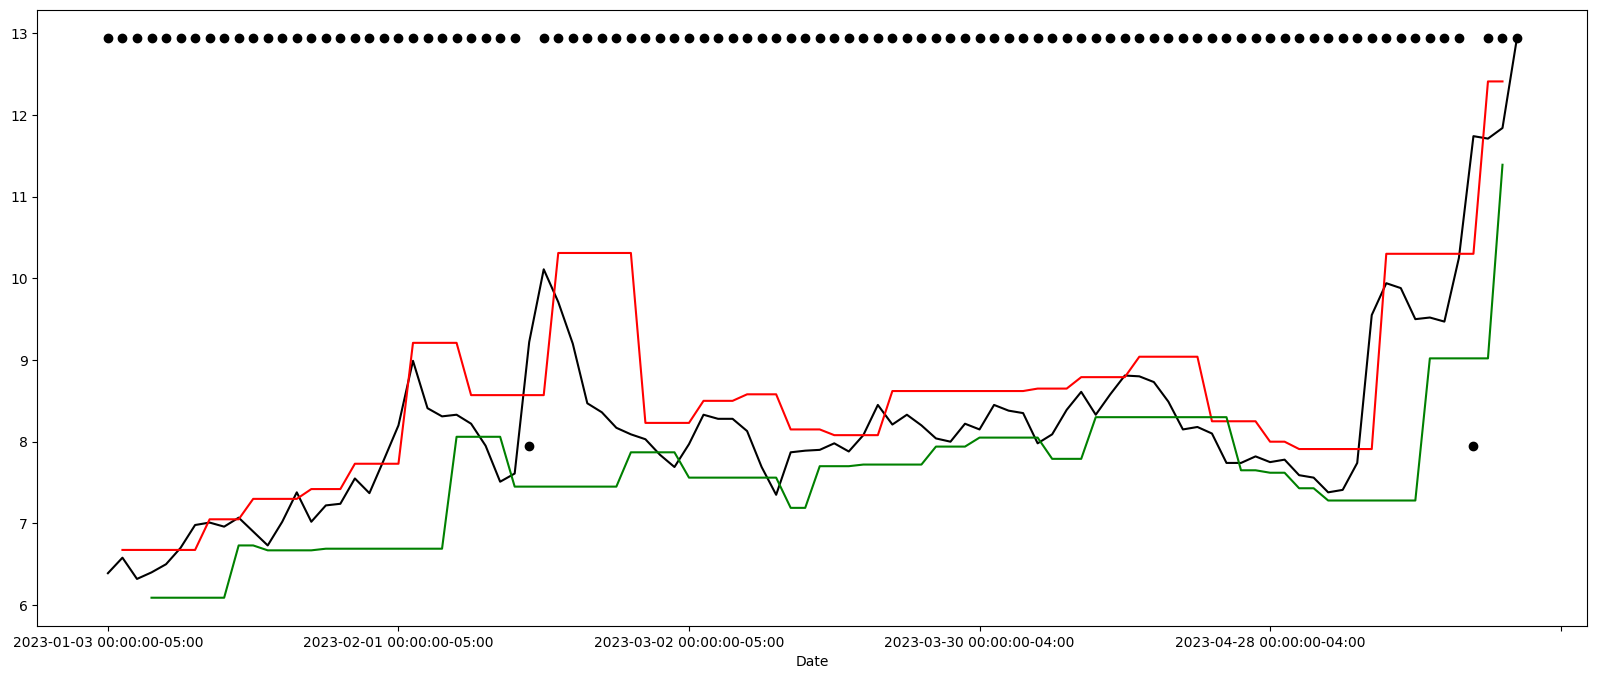

<Axes: xlabel='Date'>

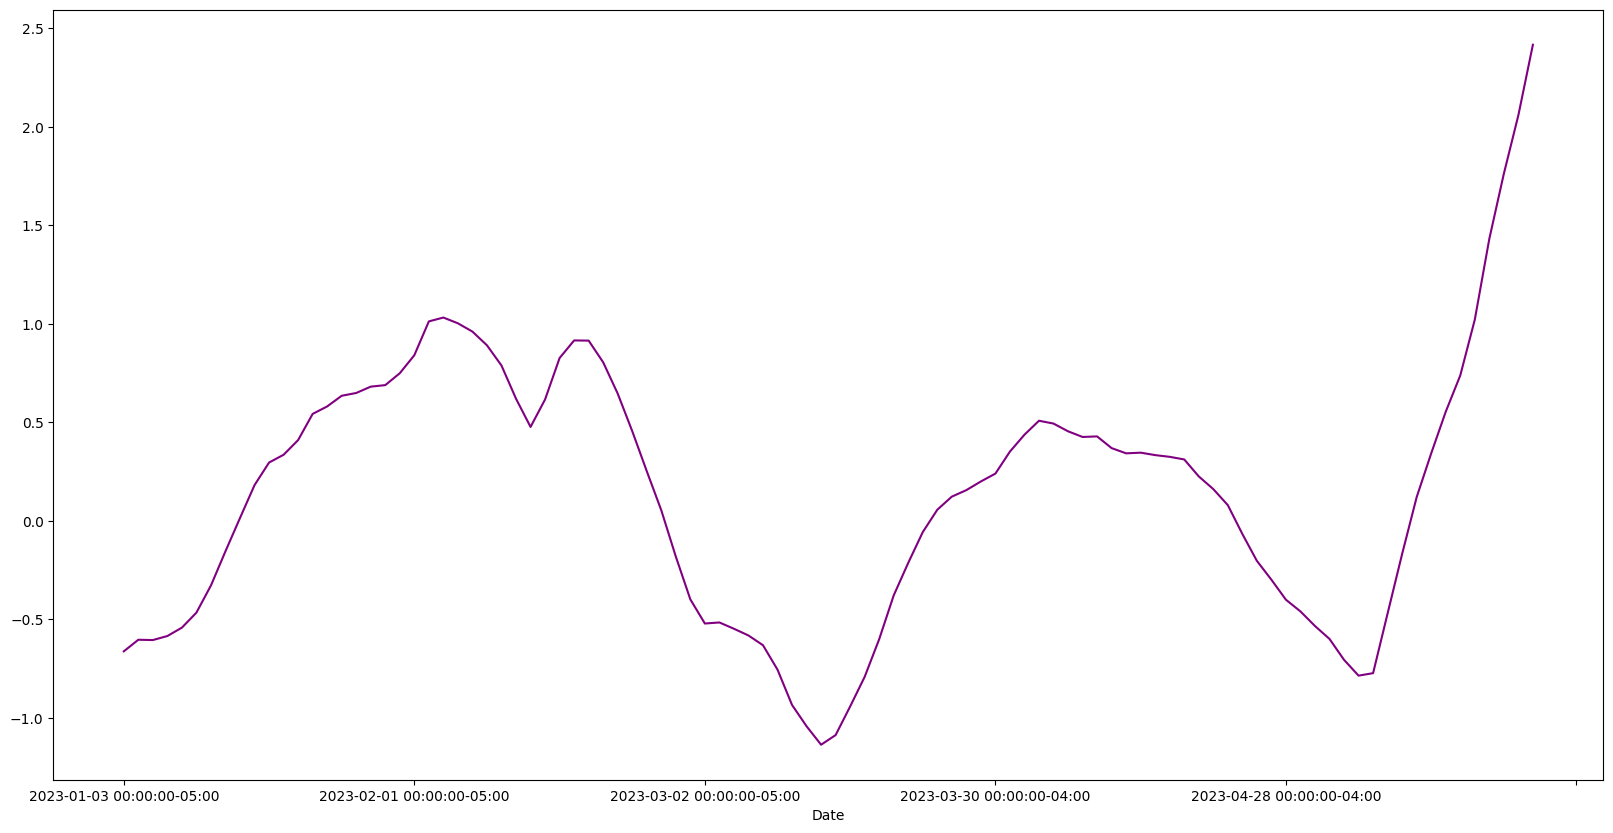

In [17]:
# graph pivots on top of price
df["Close"].plot(figsize=(20,8), color="black")

pivots["PHV"].plot(figsize=(20,8), color="red")
pivots["PLV"].plot(figsize=(20,8), color="green")
short = ta.ema(df["Volume"], 5)
long = ta.ema(df["Volume"], 10)
osc = 100*(short - long) / long


bull_cond = df["Open"] - df["Low"] > df["Close"] - df["Open"]
bull_break = ta.cross(df["Close"], pivots["PHV"]) & ~bull_cond & (osc > volume_threshold)

(bull_break.astype(int)*-5+max(df["Close"])).plot(figsize=(20,8), color="black", marker="o", linestyle="None")

plt.show()
val.plot(figsize=(20,10), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
# sqzOn.astype(int).plot(figsize=(20,14), color="pink", marker="o", linestyle="None", alpha=0.5)

<Axes: xlabel='Date'>

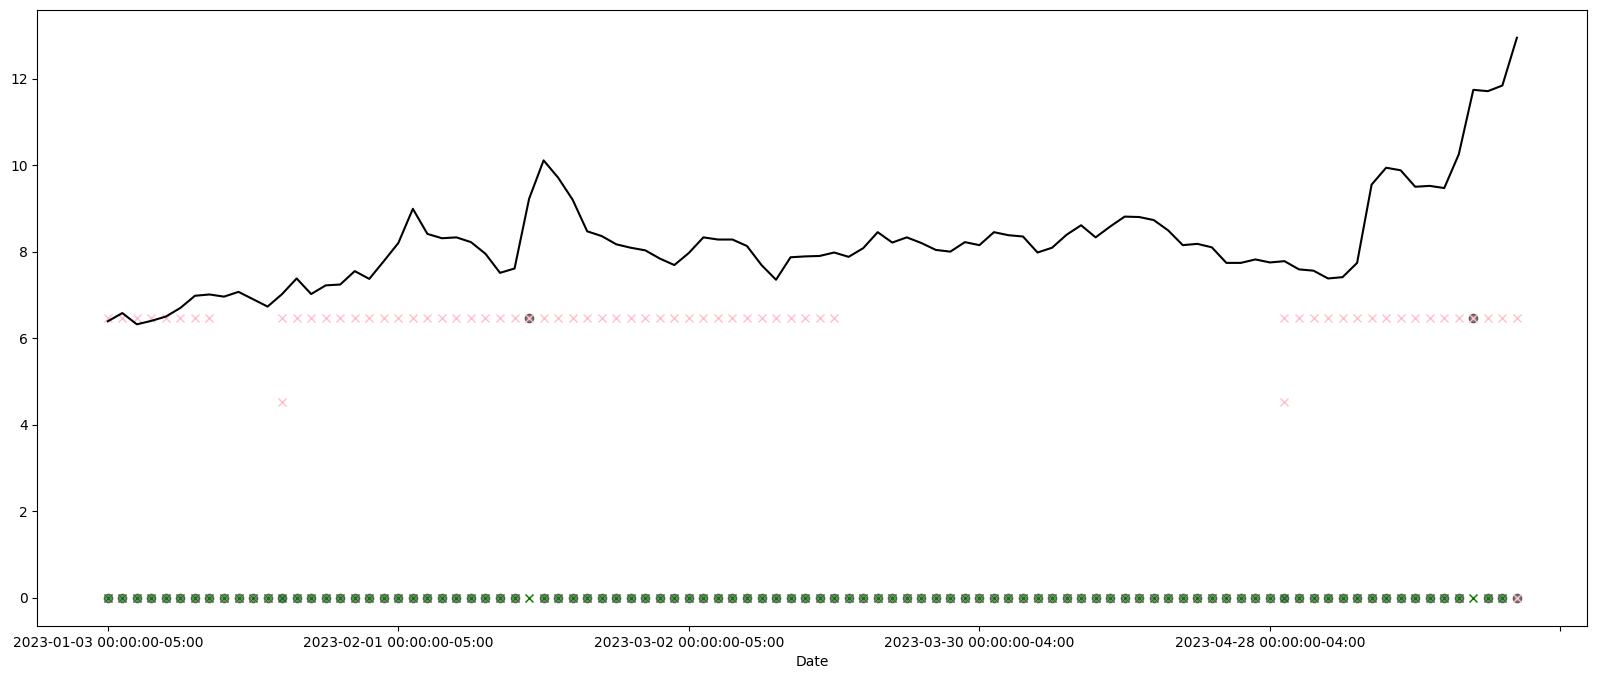

In [18]:
# identify where the squeeze turns off at the same time as a bull break

mult = 1/2 * max(df["Close"])
SENSITIVITY = 3

(bull_break.astype(int)*mult).plot(figsize=(20,8), color="black", marker="o", linestyle="None", alpha=0.5)
# sqzOff = sqzOff.astype(int).rolling(4).sum().astype(bool)
(sqzOff.astype(int)*mult).plot(figsize=(20,8), color="pink", marker="x", linestyle="None", alpha=1)

sqzTurnOff = sqzOff & ~sqzOff.shift(1).dropna()

(sqzTurnOff.astype(int)*.7*mult).plot(figsize=(20,8), color="pink", marker="x", linestyle="None", alpha=1)

intersect = bull_break.astype(int).rolling(SENSITIVITY).sum().astype(bool) & sqzTurnOff.astype(int).rolling(SENSITIVITY).sum().astype(bool)

# resample intersect to only have 1 consecutive buy signal
intersect = intersect & ~intersect.shift(1).dropna()

intersect = intersect.shift(1).dropna()

(intersect.astype(int)*1.5*mult).plot(figsize=(20,8), color="green", marker="x", linestyle="None", alpha=1)


# plot price
df["Close"].plot(figsize=(20,8), color="black")

In [19]:
# get the dates of the intersect == true
intersect_dates = intersect[intersect == True].index
intersect_dates

Index([], dtype='object', name='Date')

In [1500]:
# starting with 10k cash, buy max shares at each intersect date, sell after 10 candles

from datetime import timedelta, datetime

shares = 0
wins = []
losses = []
leverage = 1

start_cash = 1000
leveraged_cash = start_cash * leverage
cash = leveraged_cash

for i in range(len(intersect_dates)):

    buy_idx = df.index.get_loc(intersect_dates[i])+1
    buy_date = df.index[buy_idx]
    buy_price = df.loc[buy_date, "Close"] * leverage
    # index of buy date
    # index of sell date is 20 candles late
    sell_idx = buy_idx + 10
    sell_date = df.index[sell_idx]
    sell_price = df.loc[sell_date, "Close"] * leverage
    shares = cash / buy_price
    cash = shares * sell_price
    percent_change = 100*(sell_price - buy_price) / buy_price
    if sell_price > buy_price:
        wins.append(percent_change)
        # print(f"win: bought for {buy_price} and sold for {sell_price}")
    else:
        losses.append(percent_change)
        # print(f"loss: bought for {buy_price} and sold for {sell_price}")
    
    # print(f"cash: {cash}")

print(f"starting cash: {start_cash}")
print(f"ending cash: {cash}")
print(f"total profit: {cash - start_cash}")
print(f"profit %: {100*(cash - start_cash) / start_cash}")

print(f"total wins: {len(wins)}")
print(f"total losses: {len(losses)}")
if len(wins) > 0:
    print(f"avg win: {sum(wins) / len(wins)}")
if len(losses) > 0:
    print(f"avg loss: {sum(losses) / len(losses)}")

print("wins:", wins)
print("losses:", losses)

starting cash: 1000
ending cash: 957.7777650621202
total profit: -42.22223493787976
profit %: -4.222223493787976
total wins: 0
total losses: 1
avg loss: -4.222223493787977
wins: []
losses: [-4.222223493787977]


In [1501]:
# different strat: buy $100 worth of shares at each intersect date, then see valuation at the end of the period

shares = 0
buys = 0

for i in range(len(intersect_dates)):
    if i == len(intersect_dates) - 1:
        break

    buy_idx = df.index.get_loc(intersect_dates[i])+1
    buy_date = df.index[buy_idx]
    buy_price = df.loc[buy_date, "Close"]
    shares += 100 / buy_price
    buys += 1

print(f"total cash spend:", {buys * 100})
print(f"total shares bought:", {shares})
print(f"total cash at end:", {shares * df.iloc[-1]["Close"]})
print(f"total profit:", {shares * df.iloc[-1]["Close"] - buys * 100})

total cash spend: {0}
total shares bought: {0}
total cash at end: {0.0}
total profit: {0.0}


In [1503]:
from tqdm import tqdm
import os
# trying all the tickers and seeing which ones give buy signals in the last 10 candles

# iterate over ../data/1d


for filename in tqdm(os.listdir("../data/1d")):
    try:
        ticker = filename.split(".")[0]
        df = read_csv(ticker)

        import numpy as np

        # Squeeze Momentum Indicator

        LENGTH_BB = 20 # BB Length
        MULT_BB = 2 # BB Multiplier
        LENGTH_KC = 20 # KC Length
        MULT_KC = 1.5 # KC Multiplier

        USE_TRUE_RANGE = True # Use True Range for KC

        # Calculate BB
        source = df["Close"]
        basis = ta.sma(source, length=LENGTH_BB)
        dev = MULT_KC * ta.stdev(source, length=LENGTH_BB)

        upperBB = basis + dev
        lowerBB = basis - dev

        # Calculate KC
        ma = ta.sma(source, length=LENGTH_KC)
        range_val = ta.true_range(df["High"], df["Low"], df["Close"]) if USE_TRUE_RANGE else df["High"] - df["Low"]
        rangema = ta.sma(range_val, length=LENGTH_KC)
        upperKC = ma + rangema * MULT_KC
        lowerKC = ma - rangema * MULT_KC

        # Calculate Squeeze
        sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
        sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
        noSqz = ~sqzOn & ~sqzOff

        # Calculate Momentum
        avg_high_low = (df["High"].rolling(LENGTH_KC).max() + df["Low"].rolling(LENGTH_KC).min())/2
        sma_close = ta.sma(df["Close"], LENGTH_KC)
        val = ta.linreg(source - (avg_high_low + sma_close)/2, LENGTH_KC, 0)

        # replace all NaN values with 0
        val = val.replace(np.nan, 0)

        lefbars = 5
        rightbars = 5
        volume_threshold = 10

        pivots = pivotPoints(pivot=1,data=df)


        short = ta.ema(df["Volume"], 5)
        long = ta.ema(df["Volume"], 10)
        osc = 100*(short - long) / long


        bull_cond = df["Open"] - df["Low"] > df["Close"] - df["Open"]
        bull_break = ta.cross(df["Close"], pivots["PHV"]) & ~bull_cond & (osc > volume_threshold)

        mult = 1/2 * max(df["Close"])
        SENSITIVITY = 3

        sqzTurnOff = sqzOff & ~sqzOff.shift(1).dropna()

        intersect = bull_break.astype(int).rolling(SENSITIVITY).sum().astype(bool) & sqzTurnOff.astype(int).rolling(SENSITIVITY).sum().astype(bool)

        # resample intersect to only have 1 consecutive buy signal
        intersect = intersect & ~intersect.shift(1).dropna()

        intersect = intersect.shift(1).dropna()

        # get the dates of the intersect == true
        intersect_dates = intersect[intersect == True].index

        # if latest date is within last 3 days, print out the ticker
        today = datetime.now()
        if len(intersect_dates) == 0:
            continue
        last_intersect = datetime.strptime(intersect_dates[-1][:-6], "%Y-%m-%d %H:%M:%S")
        if last_intersect > today - timedelta(days=3):
            print(ticker)
    except:
        continue

  0%|          | 13/7271 [00:05<43:26,  2.78it/s] 

NVCT


  0%|          | 18/7271 [00:08<1:10:27,  1.72it/s]

AIRT


  5%|▌         | 393/7271 [03:29<1:10:08,  1.63it/s]

UBA


  6%|▌         | 416/7271 [03:44<1:08:03,  1.68it/s]

KRYS


  7%|▋         | 491/7271 [04:24<1:24:46,  1.33it/s]

EPM


  7%|▋         | 516/7271 [04:36<38:09,  2.95it/s]  

SURF


  7%|▋         | 545/7271 [04:51<1:11:21,  1.57it/s]

QTWO


  9%|▉         | 656/7271 [05:52<51:57,  2.12it/s]  

XELB


 13%|█▎        | 951/7271 [08:32<51:42,  2.04it/s]  

MAPS


 15%|█▌        | 1119/7271 [10:03<1:09:41,  1.47it/s]

RIGL


 16%|█▌        | 1135/7271 [10:14<1:04:51,  1.58it/s]

ATHM


 19%|█▉        | 1397/7271 [12:37<46:46,  2.09it/s]  

SLGC


 22%|██▏       | 1599/7271 [14:21<1:12:36,  1.30it/s]

JOF


 25%|██▍       | 1795/7271 [16:04<39:39,  2.30it/s]  

QMCO


 25%|██▍       | 1811/7271 [16:13<34:42,  2.62it/s]  

LIAN


 27%|██▋       | 1928/7271 [17:12<37:36,  2.37it/s]  

APLD


 28%|██▊       | 2008/7271 [17:54<43:08,  2.03it/s]  

MGTX


 33%|███▎      | 2398/7271 [21:18<38:49,  2.09it/s]  

ZVIA


 35%|███▌      | 2562/7271 [22:54<51:46,  1.52it/s]  

CBRL


 36%|███▌      | 2589/7271 [23:12<47:40,  1.64it/s]  

DHCNI


 36%|███▋      | 2641/7271 [23:42<48:32,  1.59it/s]

HGBL


 38%|███▊      | 2795/7271 [25:07<27:51,  2.68it/s]  

NIU


 39%|███▉      | 2825/7271 [25:25<37:10,  1.99it/s]  

PDEX


 40%|███▉      | 2883/7271 [25:52<42:38,  1.71it/s]

FL


 40%|████      | 2914/7271 [26:07<45:46,  1.59it/s]

PDSB


 41%|████      | 2947/7271 [26:26<40:09,  1.79it/s]

NWLI


 41%|████      | 2950/7271 [26:28<42:37,  1.69it/s]

GRPN


 41%|████▏     | 3017/7271 [27:03<26:14,  2.70it/s]

PTMN


 44%|████▍     | 3209/7271 [28:41<30:59,  2.18it/s]

LUXH


 45%|████▌     | 3280/7271 [29:20<40:09,  1.66it/s]

BLMN


 47%|████▋     | 3412/7271 [30:34<37:35,  1.71it/s]

CGTX


 47%|████▋     | 3414/7271 [30:35<39:20,  1.63it/s]

SVRA


 49%|████▉     | 3562/7271 [31:56<18:49,  3.28it/s]

ARVL


 50%|████▉     | 3617/7271 [32:27<26:28,  2.30it/s]

KOD


 53%|█████▎    | 3842/7271 [34:23<26:55,  2.12it/s]

MTR


 54%|█████▎    | 3893/7271 [34:48<26:00,  2.16it/s]

AMAM


 55%|█████▌    | 4003/7271 [35:52<28:40,  1.90it/s]

SNAX


 56%|█████▌    | 4037/7271 [36:10<26:26,  2.04it/s]

ENVB


 56%|█████▌    | 4089/7271 [36:39<35:38,  1.49it/s]

EMO


 57%|█████▋    | 4127/7271 [36:59<25:27,  2.06it/s]

DMAC


 57%|█████▋    | 4172/7271 [37:18<09:56,  5.20it/s]

TERN


 59%|█████▉    | 4311/7271 [38:34<26:27,  1.86it/s]

MPTI


 59%|█████▉    | 4317/7271 [38:37<22:33,  2.18it/s]

JHX


 61%|██████    | 4451/7271 [39:52<39:04,  1.20it/s]

NMIH


 62%|██████▏   | 4514/7271 [40:25<25:34,  1.80it/s]

ELTK


 64%|██████▍   | 4646/7271 [41:30<26:17,  1.66it/s]

ABC


 65%|██████▌   | 4739/7271 [42:13<14:18,  2.95it/s]

HTOO


 65%|██████▌   | 4762/7271 [42:25<23:33,  1.78it/s]

CCD


 66%|██████▌   | 4763/7271 [42:25<24:07,  1.73it/s]

OTLK


 66%|██████▋   | 4828/7271 [42:55<11:46,  3.46it/s]

RGTI


 67%|██████▋   | 4895/7271 [43:28<15:07,  2.62it/s]

RSKD


 69%|██████▉   | 5009/7271 [44:26<27:04,  1.39it/s]

ITRN


 70%|██████▉   | 5089/7271 [45:05<19:26,  1.87it/s]

TWN


 71%|███████   | 5169/7271 [45:47<23:03,  1.52it/s]

CCF


 72%|███████▏  | 5204/7271 [46:06<26:18,  1.31it/s]

HQI


 73%|███████▎  | 5283/7271 [46:49<14:56,  2.22it/s]

IH


 73%|███████▎  | 5321/7271 [47:10<12:44,  2.55it/s]

CANO


 74%|███████▍  | 5395/7271 [47:48<20:49,  1.50it/s]

LWLG


 75%|███████▌  | 5457/7271 [48:17<16:37,  1.82it/s]

DXPE


 78%|███████▊  | 5660/7271 [50:12<18:12,  1.47it/s]

XBIT


 80%|███████▉  | 5799/7271 [51:25<14:31,  1.69it/s]

RRC


 83%|████████▎ | 6045/7271 [53:25<10:18,  1.98it/s]

HTOOW


 84%|████████▍ | 6095/7271 [53:51<08:40,  2.26it/s]

RLYB


 86%|████████▌ | 6260/7271 [55:16<07:26,  2.27it/s]

BLFS


 88%|████████▊ | 6420/7271 [56:44<07:22,  1.92it/s]

RXRX


 89%|████████▉ | 6454/7271 [57:01<07:18,  1.86it/s]

SOND


 89%|████████▉ | 6484/7271 [57:18<06:54,  1.90it/s]

FSTR


 92%|█████████▏| 6708/7271 [59:24<03:31,  2.66it/s]

TSP


 94%|█████████▍| 6825/7271 [1:00:34<03:11,  2.33it/s]

LAW


 94%|█████████▍| 6852/7271 [1:00:49<04:38,  1.51it/s]

LAB


 99%|█████████▉| 7198/7271 [1:03:41<00:41,  1.75it/s]

CMRX


 99%|█████████▉| 7223/7271 [1:03:55<00:28,  1.69it/s]

APPS


100%|██████████| 7271/7271 [1:04:20<00:00,  1.88it/s]
